## 1. Ground truth model
Credits:

- Author: Gabin Rousseau
- Code source: predominantly https://github.com/Schumacher-group/cellcircuits

In [1]:
#Imports

#params
import numpy as np
from scipy.optimize import curve_fit

#analysis
from scipy.optimize import fsolve
from scipy.integrate import odeint

#main
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the inner function of the ODE: a - b*X
def inner_model(X, a, b):
    return a - b * X

# Given data for a - b*X values at various X
X_data = np.array([1, 2, 4, 8, 16, 32, 64, 128])
inner_data = np.array([0.066, 0.049, 0.030, 0.013, 0.0, -0.009, -0.015, -0.017])

# Fit the inner model
params, _ = curve_fit(inner_model, X_data, inner_data)
a_fit, b_fit = params

# Generate a smooth curve for visualization
X_fit = np.linspace(1, 130, 500)
inner_fit = inner_model(X_fit, a_fit, b_fit)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit, inner_fit, '-', label=f'Fitted: a = {a_fit:.5f}, b = {b_fit:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('X')
plt.ylabel('a - bX')
plt.title('Fitting a - bX to Match Given Growth Rates')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

a_fit, b_fit

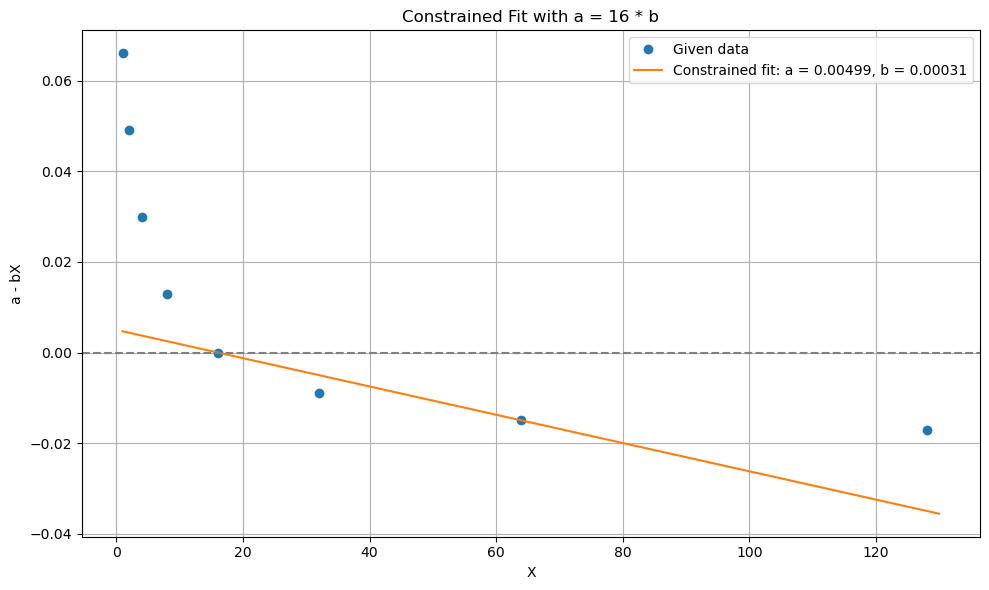

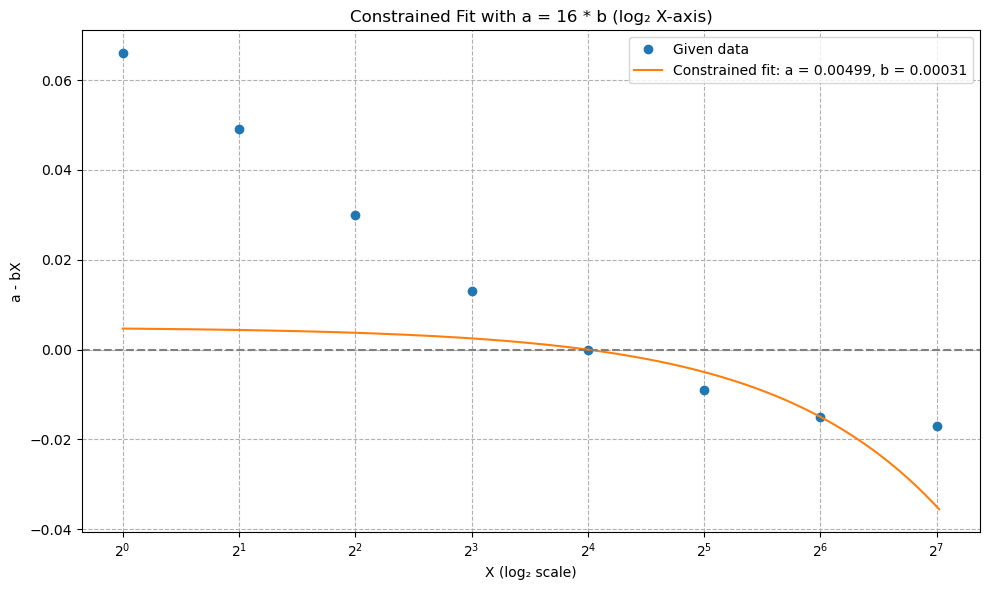

(np.float64(0.00499129218839478), np.float64(0.00031195576177467377))

In [ ]:
# constrained variant to ensure the steady state at X=16 (where a=16b)

# Redefine the model with the constraint a = 16 * b => a - bX = b(16 - X)
def constrained_model(X, b):
    return b * (16 - X)

# Fit the constrained model
from scipy.optimize import curve_fit
b_constrained, _ = curve_fit(constrained_model, X_data, inner_data)
a_constrained = 16 * b_constrained[0]

# Generate smooth curve for plotting
X_fit_constrained = np.linspace(1, 130, 500)
inner_fit_constrained = constrained_model(X_fit_constrained, b_constrained[0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('X')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the constrained fit over a log2-scaled x-axis
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xscale('log', base=2)
plt.xlabel('X (log₂ scale)')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b (log₂ X-axis)')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

a_constrained, b_constrained[0] #it seems the ODE will struggle to capture the figure S2H results properly, but still, this gives us an initial direction.

/tmp/ipykernel_108363/569969513.py:12: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-a * X)) - b*np.log2(X))


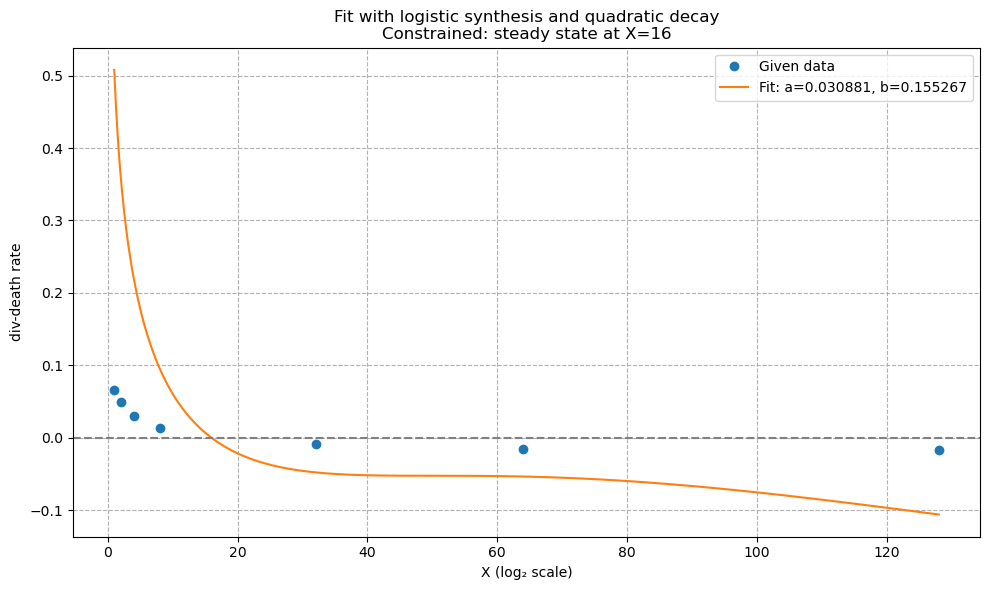

In [158]:
# Re-import necessary libraries after code environment reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Re-define data
X_data = np.array([1, 2, 4, 8, 32, 64, 128])
inner_data = np.array([0.066, 0.049, 0.030, 0.013, -0.009, -0.015, -0.017])

# Define the new model with a logistic function
def logistic_decay_model(X, a, b):
    return (1 / (1 + np.exp(-a * X)) - b*np.log2(X))

# Define residuals for least squares fitting
def residuals(params, X, y):
    a, b = params
    return np.sum((logistic_decay_model(X, a, b) - y)**2)

# Constraint: steady state at X=16
def constraint(params):
    a, b = params
    return 1 / (1 + np.exp(-a * 16)) - b*np.log2(16)

# Initial guess and bounds
initial_guess = [0.01, 0.001]
cons = {'type': 'eq', 'fun': constraint}
bounds = [(-100, 100), (-100, 100)]

# Fit model
result = minimize(residuals, initial_guess, args=(X_data, inner_data), constraints=cons, bounds=bounds)
a_fit_logistic, b_fit_logistic = result.x

# Generate fitted curve
X_fit_range = np.linspace(min(X_data), max(X_data), 500)
y_fit_logistic = logistic_decay_model(X_fit_range, a_fit_logistic, b_fit_logistic)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_range, y_fit_logistic, '-', label=f'Fit: a={a_fit_logistic:.6f}, b={b_fit_logistic:.6f}')
plt.axhline(0, color='gray', linestyle='--')
#plt.xscale('log', base=2)
plt.xlabel('X (log₂ scale)')
plt.ylabel('div-death rate')
plt.title('Fit with logistic synthesis and quadratic decay\nConstrained: steady state at X=16')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# constrained variant to ensure the steady state at X=16 (where a=16b)

# Redefine the model with the constraint a = 16 * b => a - bX = b(16 - X)
def constrained_model(X, b):
    return b * (16 - X)

# Fit the constrained model
from scipy.optimize import curve_fit
b_constrained, _ = curve_fit(constrained_model, X_data, inner_data)
a_constrained = 16 * b_constrained[0]

# Generate smooth curve for plotting
X_fit_constrained = np.linspace(1, 130, 500)
inner_fit_constrained = constrained_model(X_fit_constrained, b_constrained[0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('X')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the constrained fit over a log2-scaled x-axis
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xscale('log', base=2)
plt.xlabel('X (log₂ scale)')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b (log₂ X-axis)')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

a_constrained, b_constrained[0] #it seems the ODE will struggle to capture the figure S2H results properly, but still, this gives us an initial direction.

F cells expected SS: 16.0
M cells expected SS: 16.0
[array([0., 0.]), array([16.,  0.]), array([ 0., 16.]), array([16., 16.])]
Unstable
Unstable
Unstable
Stable


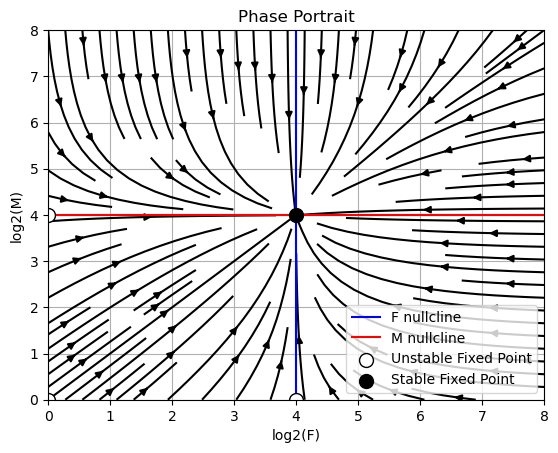

In [124]:
import autograd.numpy as np
from autograd import jacobian

#######################################
##### OSDR known model parameters #####
#######################################

# After the description of the neighbourhood dynamics ODE in Methods, we have
# dX/dt = X(p^+(X) - p^-(X)), with constant division rate parameter p^+(X) = 0X + a, and death rate parameter p^-(X) = bX + 0.

# THUS: dX/dt = aX - bX^2, a logistic equation that fits simple autocatalysis models in molecular systems biology

# Steady state: X = 0 (unstable), X = a/b. So, if we want the steady state to be at 16 cells in the neighbourhood (4 on a log2 scale) of the same type (S2H)
# ... we want a = 16*b

# We expect this equation to have X decrease above its 16 SS, and increase below. This value is chosen to best correspond to the neighbourhood dynamics drawn in S2H.

#F parameters
F_a=48*10**-4
F_b=3*10**-4
print(f"F cells expected SS: {F_a/F_b}") #check for float-related errors (e.g. slightly incorrect result)

#M parameters
M_a=48*10**-4
M_b=3*10**-4
print(f"M cells expected SS: {M_a/M_b}")

# Define the system of ODEs
def ODE_system(state):
    F, M = state
    dF_dt = F * (F_a - F_b * F)
    dM_dt = M * (M_a - M_b * M)
    return [dF_dt, dM_dt]

def ODE_system_np(state):
    F, M = state
    dF_dt = F * (F_a - F_b * F)
    dM_dt = M * (M_a - M_b * M)
    return np.array([dF_dt, dM_dt])


# Generate rates for streamlines adapted to the log2 scale
def streamlines(exp_F, exp_M):
    F = 2**exp_F
    M = 2**exp_M
    dF_dt, dM_dt = ODE_system([F, M])
    return dF_dt, dM_dt


# Find nullclines using fsolve
def nullclines():
    F_range = np.logspace(0, 8, 400, base=2)
    M_range = np.logspace(0, 8, 400, base=2)

    F_nullcline = [fsolve(lambda F: ODE_system([F, M])[0], F_a/F_b) for M in M_range]
    M_nullcline = [fsolve(lambda M: ODE_system([F, M])[1], M_a/M_b) for F in F_range]
    
    return F_range, M_range, F_nullcline, M_nullcline

# Find fixed points using fsolve
def find_fixed_points():
    expected = [[0, 0], [F_a / F_b, 0], [0, M_a / M_b], [F_a / F_b, M_a / M_b]]
    fixed_points = [fsolve(ODE_system, expectation) for expectation in expected]
    return fixed_points

# Calculate stability using the Jacobian
def is_stable(fp):
    jac = jacobian(ODE_system_np)
    J = jac(fp)
    eigenvalues = np.linalg.eigvals(J)
    return all(e.real < 0 for e in eigenvalues)

def not_unstable(fp):
    jac = jacobian(ODE_system_np)
    J = jac(fp)
    eigenvalues = np.linalg.eigvals(J)
    return all(e.real <= 0 for e in eigenvalues)

# Plot the phase portrait
def plot_phase_portrait():
    # Parameters for meshgrid
    exp_F_mesh = np.linspace(0, 8, 30)
    exp_M_mesh = np.linspace(0, 8, 30)
    exp_F, exp_M = np.meshgrid(exp_F_mesh, exp_M_mesh)

    # Calculate the growth rates for the streamlines
    F_rate, M_rate = streamlines(exp_F, exp_M)
    F_rate_scaled = F_rate / (2**exp_F)
    M_rate_scaled = M_rate / (2**exp_M)
    
    plt.figure()

    # Streamplot
    plt.streamplot(exp_F, exp_M, F_rate_scaled, M_rate_scaled,
                   color="black")

    # Nullclines
    F_range, M_range, F_nullcline, M_nullcline = nullclines()
    plt.plot(np.log2(F_nullcline), np.log2(M_range), 'b-', label='F nullcline')
    plt.plot(np.log2(F_range), np.log2(M_nullcline), 'r-', label='M nullcline')
    

    # Fixed points
    fixed_points = find_fixed_points()
    print(fixed_points)
    # with stability analysis
    label_added = {'Stable': False, 'Unstable': False, 'Semi-stable': False} #point label tracker to avoid redundancy
    for fp in fixed_points:
        x=(np.log2(fp[0])) if fp[0]!=0 else fp[0]
        y=(np.log2(fp[1])) if fp[1]!=0 else fp[1]
        stability=''
        if is_stable(fp):
            stability = 'Stable'
        elif not_unstable(fp):
            stability = 'Semi-stable'
        else:
            stability = 'Unstable'
        print(stability)
        fcolor = 'black' if stability == 'Stable' or stability == 'Semi-stable' else 'white'
        ecolor = 'black' if stability == 'Stable' or stability =='Unstable' else 'red'
        if label_added[stability]==False:
            plt.scatter(x, y, s=100, edgecolors=ecolor, facecolors=fcolor, label=f'{stability} Fixed Point', zorder=2)
            label_added[stability]=True
        else:
            plt.scatter(x, y, s=100, edgecolors=ecolor, facecolors=fcolor, zorder=2)

    # Labels and legend
    plt.xlabel('log2(F)')
    plt.ylabel('log2(M)')
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.title('Phase Portrait')
    plt.grid(True)
    plt.show()

plot_phase_portrait()



# 2. Simulation of cell distribution data biased by predefined model of division/death

In [4]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
# parameters
cells=["F","M"] #cell type list

#n=100 #steps for stochastic proliferation

x_boundaries=(0,2500) #tissue size x boundaries in microns
y_boundaries=(0,2500) #tissue size y boundaries in microns

r=80 #neighbourhood radius in microns, same as in Somer et al.

#mF_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #division-death rate of mF based on #mF in neighbourhood
#M_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #same but with M for #M neibourhood

In [ ]:
# 1. Sample a random initial number of cells for each type (integrated in the next block)
mF_num=round(np.random.uniform(1, 10000))
print(f"Number of mF cells chosen: {mF_num}.")
M_num=round(np.random.uniform(1, 10000))
print(f"Number of M cells chosen: {M_num}.")

Number of mF cells chosen: 8712.
Number of M cells chosen: 5715.


In [132]:
# 2. Sample a random spatial position in the tissue for each cell.


def random_tissue(cells):
    cell_type=[]
    position_x=[]
    position_y=[]
    for cell in cells:
        cell_num=round(np.random.uniform(500, 9500))
        print(f"Number of {cell} cells chosen: {cell_num}.")
        for i in range(0, cell_num):
            cell_type.append(f"{cell}")
            position_x.append(np.random.uniform(x_boundaries[0],x_boundaries[1]))
            position_y.append(np.random.uniform(y_boundaries[0],y_boundaries[1]))
    tissue=pd.DataFrame(list(zip(cell_type,position_x,position_y)), columns=["Cell_Type","X","Y"])
    
    # Get all spatial coordinates as array for query
    coordinates = tissue[['X', 'Y']].values
    
    for cell in cells:
        # Build KD-Trees for each cell
        tree = cKDTree(tissue[tissue['Cell_Type'] == cell][['X', 'Y']].values)
        #Search neihbourhood contents of the current cell type for all cells
        neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == cell else 0)
               for coords, cat in zip(coordinates, tissue['Cell_Type'])]
        column_name=f"#{cell}_neighbours"
        tissue[column_name] = neighbours
        tissue[column_name+"_log2"] = np.log2(neighbours)
        print(np.isneginf(tissue[column_name+"_log2"]).any())
     
    return tissue

tissue=random_tissue(cells)
print(tissue.head())


Number of F cells chosen: 8832.
Number of M cells chosen: 729.
False
True
  Cell_Type            X            Y  #F_neighbours  #F_neighbours_log2  \
0         F  1365.161901  1084.413889             28            4.807355   
1         F  1102.438757  2435.828616             24            4.584963   
2         F  2091.487750    16.868427             22            4.459432   
3         F   892.774511   602.014954             34            5.087463   
4         F  1025.229515  2368.226750             33            5.044394   

   #M_neighbours  #M_neighbours_log2  
0              3            1.584963  
1              1            0.000000  
2              1            0.000000  
3              1            0.000000  
4              2            1.000000  


/home/gabinrousseau/miniconda3/envs/osdr/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log2
  return f_raw(*args, **kwargs)


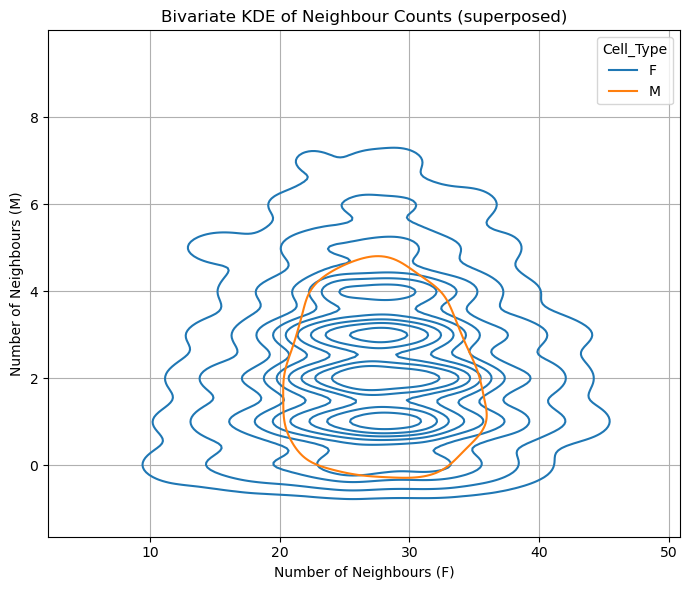

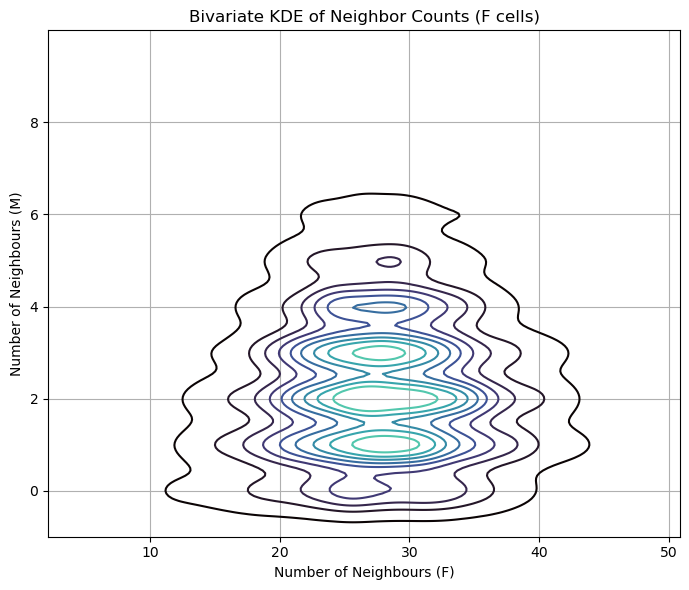

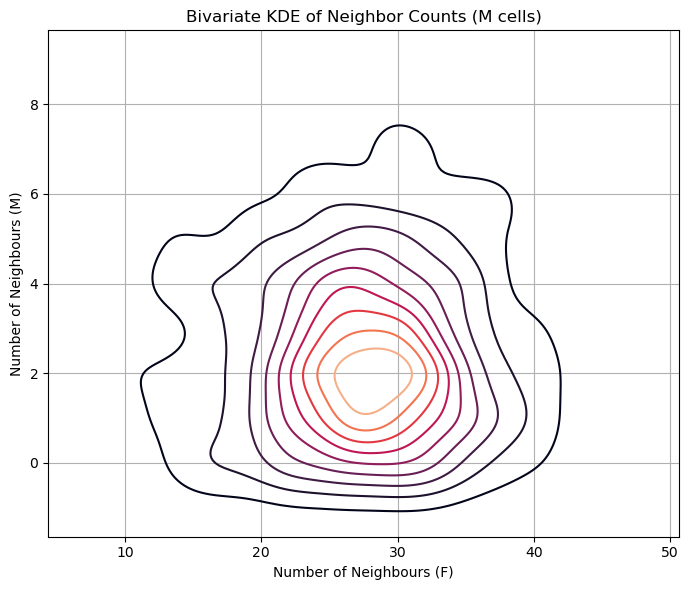

In [133]:
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=tissue,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.xlabel('Number of Neighbours (F)')
plt.ylabel('Number of Neighbours (M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = tissue[tissue['Cell_Type'] == 'F']
df_M = tissue[tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()


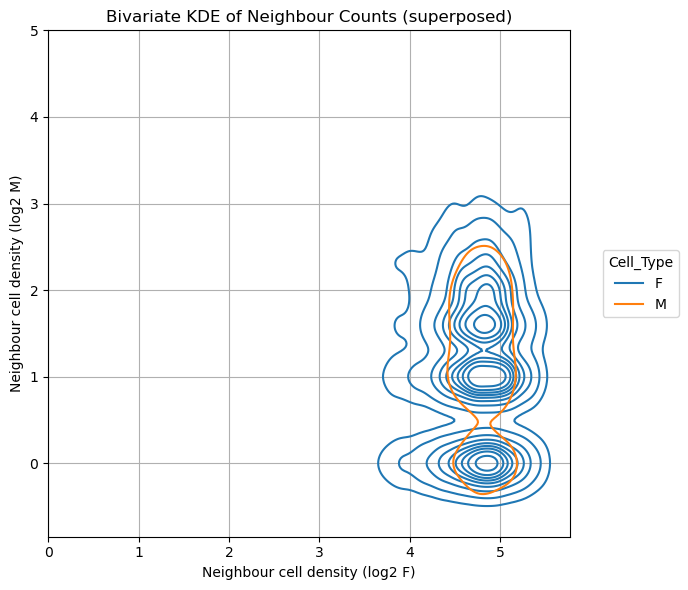

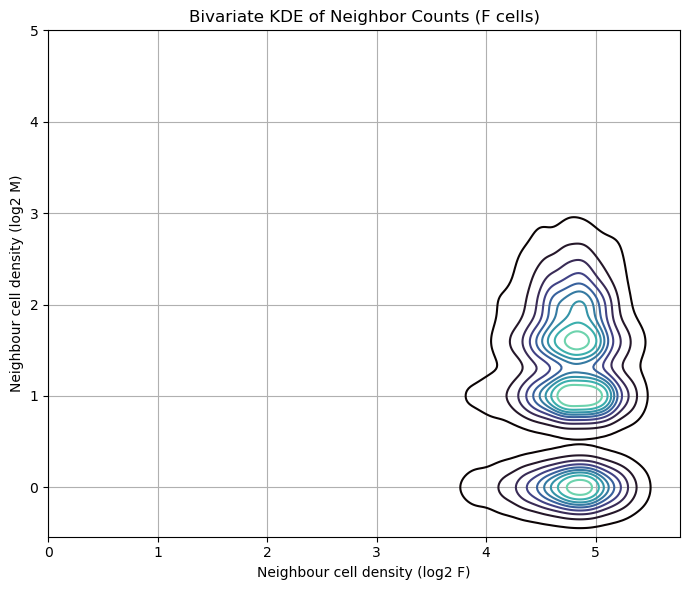

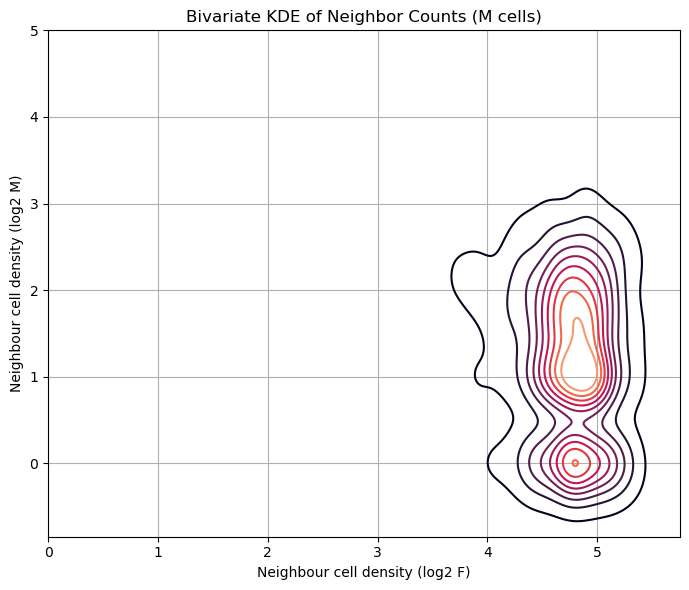

In [134]:
####LOG2 PLOTS####
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
log2_tissue=tissue[np.isfinite(tissue["#F_neighbours_log2"]) & np.isfinite(tissue["#M_neighbours_log2"])]
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=log2_tissue,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.gca().get_legend().set_bbox_to_anchor((1.05, 0.5))
plt.gca().get_legend().set_loc('center left')
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel('Neighbour cell density (log2 F)')
plt.ylabel('Neighbour cell density (log2 M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = log2_tissue[log2_tissue['Cell_Type'] == 'F']
df_M = log2_tissue[log2_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()


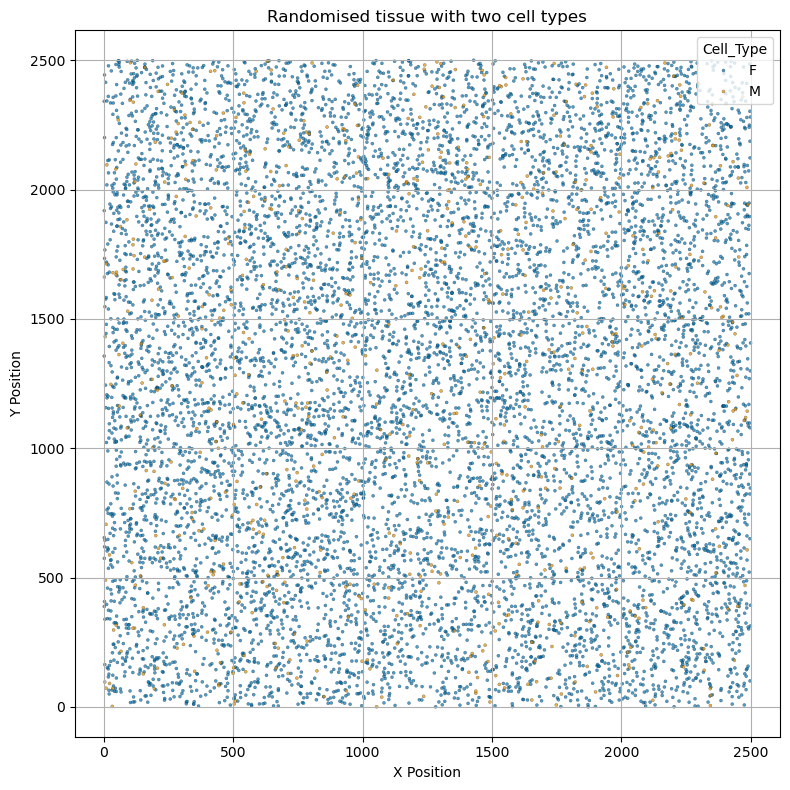

In [135]:
#Show cells of the generated tissue

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=tissue,
    x='X',
    y='Y',
    hue='Cell_Type',
    palette='colorblind',   
    s=5,             
    edgecolor='black',
    alpha=0.7
)
plt.title("Randomised tissue with two cell types")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

## STOCHASTIC SIM

### NON-PARALLELISED VERSION

In [136]:
from tqdm import tqdm
#F parameters
F_a=48*10**-4
F_b=3*10**-4

#M parameters
M_a=48*10**-4
M_b=3*10**-4


# 3. stochastic biased proliferation over n steps

def tissue_proliferation(tissue, n=100, t=1): #time value, multiplies the rates
    div_counter=0
    death_counter=0
    stay_counter=0
    for step in tqdm(range(0,n)):
        next_tissue=tissue.copy()
        dead_ids=[]

        for cell_id in range(0,len(tissue)):
            #get current cell
            cell=tissue.iloc[cell_id]

            #get event probabilities
            p_div=F_a*t if cell.iloc[0]=="F" else M_a*t
            p_death=F_b*cell.iloc[3]*t if cell.iloc[0]=="F" else M_b*cell.iloc[5]*t
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                break

            #sample random event uniformly
            r1=np.random.uniform(0,1) #sample event for current cell

            #act on sampled event
            if r1 <= p_div: #division
                rx=np.random.uniform(-r,r)
                ry=np.random.uniform(-r,r)

                #prevent out of bounds and excessive proliferation on the edges
                if cell.iloc[1]+rx < 0 :
                    rx=np.random.uniform(0,r)
                elif cell.iloc[1]+rx > 2500 :
                    rx=np.random.uniform(-r,0)
                if cell.iloc[2]+ry < 0:
                    ry=np.random.uniform(0,r)
                elif cell.iloc[2]+ry > 2500:
                    ry=np.random.uniform(-r,0)
                
                new_cell=[cell.iloc[0],cell.iloc[1]+rx,cell.iloc[2]+ry,2,1,2,1]

                next_tissue.loc[len(next_tissue)]=new_cell
                
                div_counter+=1
            elif r1 <=p_div+p_death: #death
                dead_ids.append(cell_id)
                death_counter+=1
            elif r1<=p_div+p_death+p_stay: #nothing happens
                stay_counter+=1
                pass
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                break
        
        #remove chosen dead cells
        next_tissue=next_tissue.drop(dead_ids)
        next_tissue=next_tissue.reset_index(drop=True)

        #recompute neighbours
        coordinates = next_tissue[['X', 'Y']].values
        for type in cells:
            # Build KD-Trees for each cell type
            tree = cKDTree(next_tissue[next_tissue['Cell_Type'] == type][['X', 'Y']].values)
            #Search neihbourhood contents of the current cell type for all cells
            neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == type else 0)
                for coords, cat in zip(coordinates, next_tissue['Cell_Type'])]
            column_name=f"#{type}_neighbours"
            next_tissue[column_name] = neighbours
            with np.errstate(divide='ignore', invalid='ignore'): #only log2 of 0 are expected to be compute, leading to -inf values. The log2 plots ignore these so just silence runtime warnings.
                next_tissue[column_name+"_log2"] = np.log2(neighbours)

        tissue=next_tissue.copy()
    print(f"Divisions: {div_counter}\nDeaths: {death_counter}\nStay events: {stay_counter}")
    return tissue



### PARALLELISED VERSION

In [ ]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
#F parameters
F_a=48*10**-4
F_b=3*10**-4

#M parameters
M_a=48*10**-4
M_b=3*10**-4


# 3. stochastic biased proliferation over n steps

def cell_action(cell_id, t=1):
            global now_tissue
    #get current cell
            cell=now_tissue.iloc[cell_id]

            #get event probabilities
            p_div=F_a*t if cell.iloc[0]=="F" else M_a*t
            p_death=F_b*cell.iloc[3]*t if cell.iloc[0]=="F" else M_b*cell.iloc[5]*t
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                return

            #sample random event uniformly
            r1=np.random.uniform(0,1) #sample event for current cell

            #act on sampled event
            if r1 <= p_div: #division
                rx=np.random.uniform(-r,r)
                ry=np.random.uniform(-r,r)

                #prevent out of bounds and excessive proliferation on the edges
                if cell.iloc[1]+rx < 0 :
                    rx=np.random.uniform(0,r)
                elif cell.iloc[1]+rx > 2500 :
                    rx=np.random.uniform(-r,0)
                if cell.iloc[2]+ry < 0:
                    ry=np.random.uniform(0,r)
                elif cell.iloc[2]+ry > 2500:
                    ry=np.random.uniform(-r,0)
                
                new_cell=[cell.iloc[0],cell.iloc[1]+rx,cell.iloc[2]+ry,2,1,2,1]
                return new_cell

                #next_tissue.loc[len(next_tissue)]=new_cell
                
            elif r1 <=p_div+p_death: #death
                #dead_ids.append(cell_id)
                return cell_id
            elif r1<=p_div+p_death+p_stay: #nothing happens
                return None
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                return "Error"

def tissue_proliferation(tissue, n=100, t=1): #time value, multiplies the rates
    global now_tissue
    now_tissue=tissue.copy()
    div_counter=0
    death_counter=0
    stay_counter=0
    for step in tqdm(range(0,n)):
        
        #safely set the next iteration of the dataframe for edits rather than the current one being looked into
        next_tissue=now_tissue.copy()
        #ids of dead cell row storage
        dead_ids=[]


        #argument list for starmap
        starguments=[(cell_id, t) for cell_id in now_tissue.index]

        #parallelise cell-specific event sampling and post-process results
        with Pool(processes=cpu_count()) as pool:
            results = pool.starmap(cell_action, starguments)
        for result in results:
            if type(result)==int:
                dead_ids.append(result)
                death_counter+=1
            elif type(result)==list:
                next_tissue.loc[len(next_tissue)]=result
                div_counter+=1
            elif type(result)==type(None):
                stay_counter+=1
            elif result=="Error":
                raise ValueError
            else:
                print("Unexpected starmap result while parsing.")
                print(type(result))
                
        #remove chosen dead cells
        next_tissue=next_tissue.drop(dead_ids)
        next_tissue=next_tissue.reset_index(drop=True)

        #recompute neighbours
        coordinates = next_tissue[['X', 'Y']].values
        for ctype in cells:
            # Build KD-Trees for each cell type
            tree = cKDTree(next_tissue[next_tissue['Cell_Type'] == ctype][['X', 'Y']].values)
            #Search neihbourhood contents of the current cell type for all cells
            neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == ctype else 0)
                for coords, cat in zip(coordinates, next_tissue['Cell_Type'])]
            column_name=f"#{ctype}_neighbours"
            next_tissue[column_name] = neighbours
            with np.errstate(divide='ignore', invalid='ignore'): #only log2 of 0 are expected to be compute, leading to -inf values. The log2 plots ignore these so just silence runtime warnings.
                next_tissue[column_name+"_log2"] = np.log2(neighbours)

        now_tissue=next_tissue.copy()
    print(f"Divisions: {div_counter}\nDeaths: {death_counter}\nStay events: {stay_counter}")
    return now_tissue

In [137]:
#Run simulation
proliferated_tissue=tissue_proliferation(tissue, n=3000, t=1)
print(proliferated_tissue.head())

100%|██████████| 3000/3000 [27:44<00:00,  1.80it/s]

Divisions: 139063
Deaths: 138318
Stay events: 28831134
  Cell_Type            X            Y  #F_neighbours  #F_neighbours_log2  \
0         M  2136.210682  1931.161287             18            4.169925   
1         M  2006.257047  2039.821195             20            4.321928   
2         F     7.564000  2490.186496              7            2.807355   
3         M   582.416775   680.871389             11            3.459432   
4         F   273.362748  1680.567819             22            4.459432   

   #M_neighbours  #M_neighbours_log2  
0             17            4.087463  
1             17            4.087463  
2              6            2.584963  
3             17            4.087463  
4             14            3.807355  


In [116]:
len(proliferated_tissue)

10316

## PLOTS

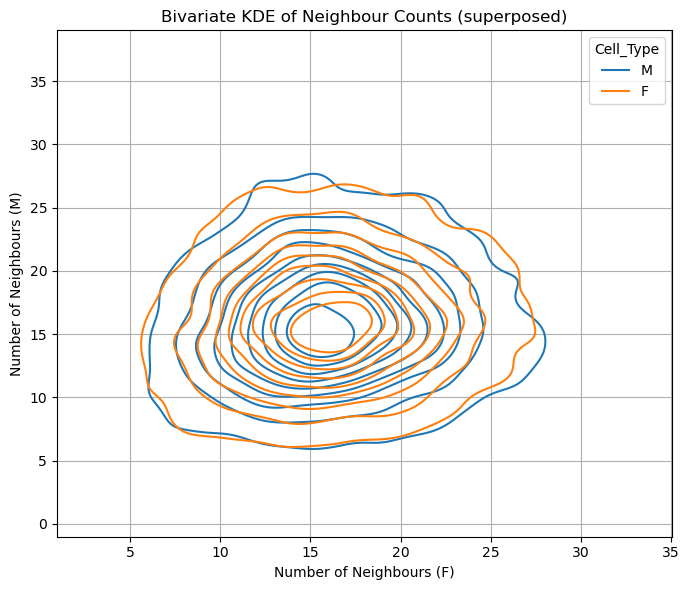

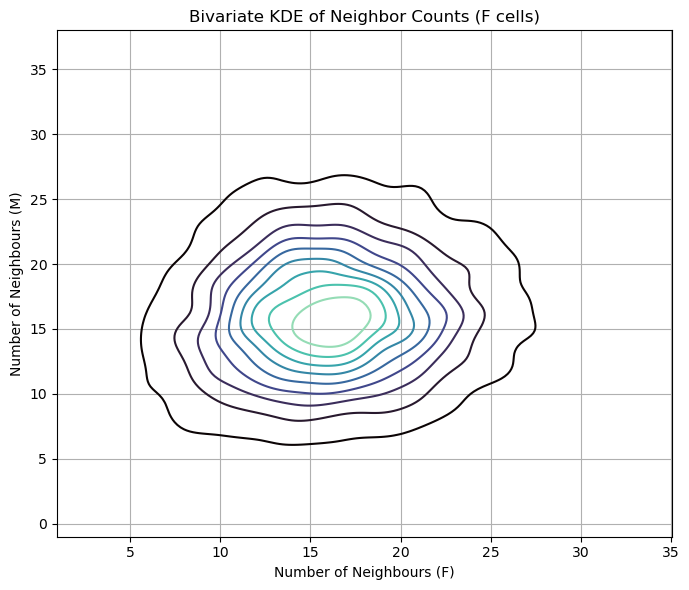

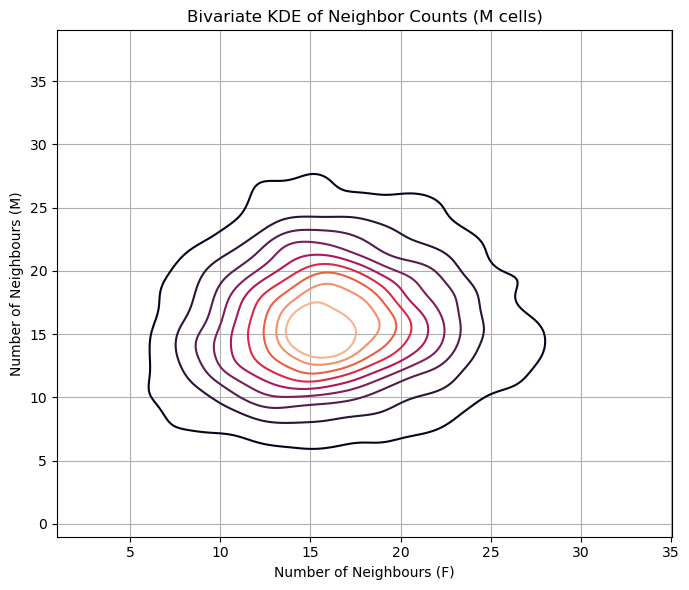

In [117]:
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=proliferated_tissue,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.xlabel('Number of Neighbours (F)')
plt.ylabel('Number of Neighbours (M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = proliferated_tissue[proliferated_tissue['Cell_Type'] == 'F']
df_M = proliferated_tissue[proliferated_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()


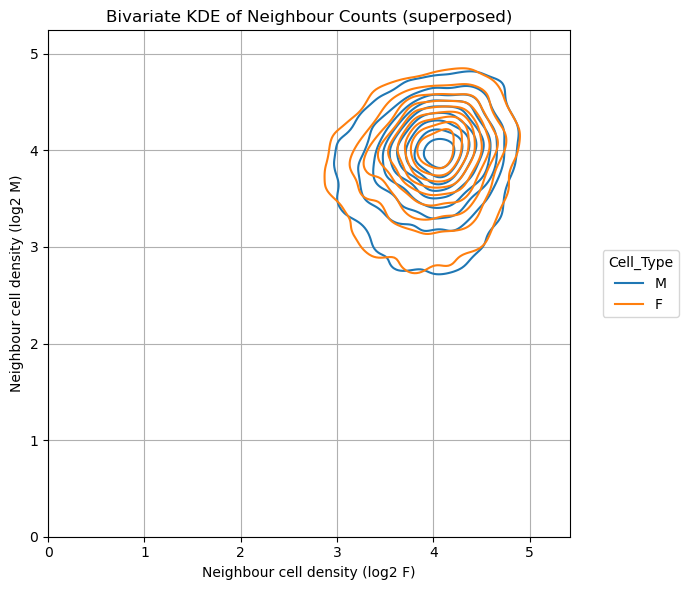

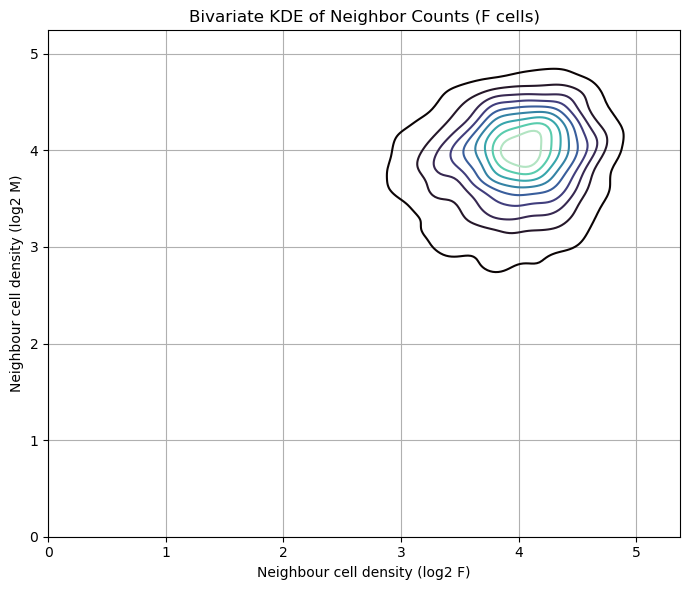

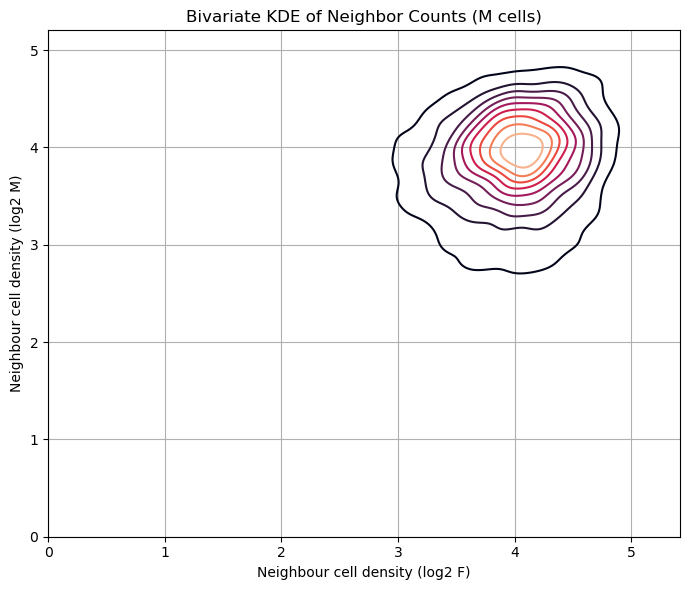

In [138]:
####LOG2 PLOTS####
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
log2_tissue=proliferated_tissue[np.isfinite(proliferated_tissue["#F_neighbours_log2"]) & np.isfinite(proliferated_tissue["#M_neighbours_log2"])]
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=log2_tissue,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.gca().get_legend().set_bbox_to_anchor((1.05, 0.5))
plt.gca().get_legend().set_loc('center left')
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel('Neighbour cell density (log2 F)')
plt.ylabel('Neighbour cell density (log2 M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = log2_tissue[log2_tissue['Cell_Type'] == 'F']
df_M = log2_tissue[log2_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()


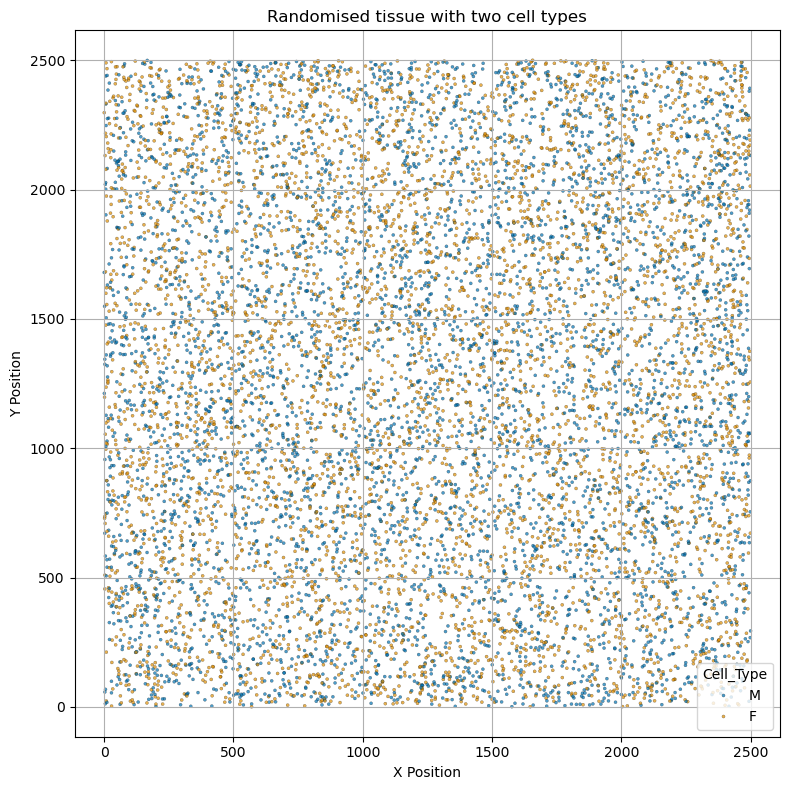

In [139]:
#Show cells of the generated tissue
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=proliferated_tissue,
    x='X',
    y='Y',
    hue='Cell_Type',
    palette='colorblind',   
    s=5,             
    edgecolor='black',
    alpha=0.7
)
plt.title("Randomised tissue with two cell types")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()